## NB3: The multispecies coalescent in space and time

This notebook should be run after completing both nb1 and nb2. Here we simulate both genealogies and sequences and compare the inferred gene trees to the true genealogies at positions in the genome. We show that the decaying similarity of gene trees in space can provide useful information for improving local gene tree estimation. 

In [1]:
# conda create -n ipcoal python=3.7
# conda activate ipcoal
# conda install ipcoal -c conda-forge -c bioconda

In [364]:
import ipcoal
import toytree
import toyplot, toyplot.svg
import numpy as np
import pandas as pd
import scipy.stats
import time
import os
import copy

In [ ]:
# parallel processing Py3
from concurrent.futures import ProcessPoolExecutor

In [4]:
# print versions of our libraries 
print('toytree', toytree.__version__)
print('ipcoal', ipcoal.__version__)

toytree 1.1.2
ipcoal 0.1.0


In [5]:
# make a subdirectory for storing some working files
WORKDIR = "results"
os.makedirs(WORKDIR, exist_ok=True)

### Function to simulate genealogies
This will be used to explore the effect of Ne, r, height, ntips on genealogical patterns distributed spatially across a genome. 

In [6]:
def sim_locus_fixed_t(ntips, height, coal, nloci, nsites, seed=123):
    """
    Return an ipcoal.Model object with genealogies simulated
    for 'nloci' and 'nsites' on an imbalanced 'tree' with Ne auto
    scaled so that all internal edges are 'coal' units long. 
    """
    # generate imbalanced tree
    tree = toytree.rtree.imbtree(ntips=ntips)
    tree = tree.mod.node_scale_root_height(height, include_stem=True)
    
    # get internode dist
    dist = tree.treenode.dist
    
    # get Ne by scaling coalunits by internode height
    Ne = dist / (coal * 2.)
    
    # init model and sim n unlinked genealogies
    model = ipcoal.Model(tree, Ne=Ne, seed=seed)
    model.sim_loci(nloci=nloci, nsites=nsites)
    return model

### Function to compare gene trees and genealogies

In [7]:
def get_RF_gtge(gt, ge, normalize=False):
    """
    Input is two dataframes, the first empirical with 
    .inferred_trees and the second simulated with 
    .genealogies. It returns a dataframe with RF distances
    between the trees at every position of the genome. 
    """
    
    # combine the indices
    pos = sorted(set(gt.start.tolist() + ge.start.tolist()))
    end = pos[1:] + [max(set(gt.end.tolist() + ge.end.tolist()))]

    # organize for output
    data = pd.DataFrame({
        "start": pos,
        "end": end,
        "length": [i - j for (i, j) in zip(end, pos)],
        "rf": 0,
        "rfsum": 0,
    })

    # get rf dists 
    for idx in data.index:
        
        # get rows
        mt = gt.loc[gt.end > data.start[idx]]
        me = ge.loc[ge.end > data.start[idx]]
        
        # get indices
        nt = gt.loc[mt.index.min(), "inferred_tree"]
        ne = ge.loc[me.index.min(), "genealogy"]
        
        # get treenodes
        tt = toytree.tree(nt).treenode
        te = toytree.tree(ne).treenode
        
        # get rf dist
        if normalize:
            rf, rfmax = tt.robinson_foulds(te, unrooted_trees=True)[:2]
            rf = rf / rfmax
        else:
            rf = tt.robinson_foulds(te, unrooted_trees=True)[0]
            
        # store result
        data.loc[idx, "rf"] = rf
        data.loc[idx, "rfsum"] = rf * data.loc[idx, "length"]
    
    return data

### Function to plot RF dists

In [8]:
def plot_rf_empirical_inferred(sliding, maxpos=None):
    """
    Draws RF dist along the chromosome from an input
    dictionary of dataframes {name: dataframe}.
    Dataframes have start and rf as columns.
    """   
    # get drawing setup
    canvas = toyplot.Canvas(width=600, height=250)
    axes = canvas.cartesian()
    
    # add markers
    for key, rfdf in sliding.items():
        
        # get index of (optional) maxpos
        if maxpos:
            idx = rfdf.loc[rfdf.start < maxpos].index.max()
            rfdf = rfdf.iloc[:idx]
        
        # plot it
        axes.plot(
            rfdf.start[:maxpos], 
            rfdf.rf[:maxpos],
            stroke_width=1.5,
            opacity=0.75,
        )
    
    # add styling
    axes.x.ticks.show = True
    axes.y.ticks.show = True
    return canvas, axes

### Infer empirical gene trees in windows

In [9]:
# window_sizes = [1000, 2500, 10000, 25000, 250000, 1000000]

# # store standard sliding window results
# sliding = {}
# for wsize in window_sizes:
    
#     # get estimated gene trees
#     edata = model.infer_gene_tree_windows(wsize, 'raxml', {'T': '8'})
    
#     # get RF between estimated and true
#     sliding[wsize] = get_RF_gtge(edata, model.df)
    
#     # save to CSV
#     sliding[wsize].to_csv(os.path.join(WORKDIR, "window-RF-{}.csv".format(wsize)))

Reload sliding dictionary from datafiles in case we restart the notebook from this point. 

In [10]:
# import glob

# # get csv files
# keys = glob.glob(os.path.join(WORKDIR, "window-RF-*.csv"))

# # reload dictionary
# sliding = {}
# for key in sorted(keys):
    
#     # get window size
#     wsize = int(key.split("-w")[-1].split(".csv")[0])
    
#     # load dataframe
#     df = pd.read_csv(key, index_col=0)
#     sliding[wsize] = df
    
#     # print summed RFs integrated over all sites
#     print(key, "\t", sliding[wsize].rfsum.sum())

#### Plot RF across genome

In [11]:
# plot_rf_empirical_inferred(sliding, 1000000);

### Infer empirical gene trees in *weighted* sliding windows

Here we will apply an exponential weighting to sites that decays away from the center of the sliding window. The decay function can be any rate, but we show that the rate estimated from the species tree model performs the best. 

In [176]:
# define parallel func
def func(midpoint, decay, vals):
    exp = scipy.stats.expon(loc=midpoint, scale=abs(1. / decay))
    return [exp.pdf(i) for i in vals]

In [278]:
def get_exponential_weight_window(seq, midpoint, decay, maxweight=100):
    """
    For an alignment create a weight file covering the full
    length and which decays exponentially from the midpoint
    according to an exponential decay lambda parameter. The
    weights file will be scaled to integers and used in raxml.
    The min weight is set to 1 and the max weight is set to 
    whatever multiplier is needed to scale weights. The max
    weight argument determines the endpoints to trim the seq
    and the seq is returned with only regions that have weight.
    Example:
               mid
    ------------^---------------------------
               / \
    __________/   \_________________________
    0011111111489841111111100000000000000000
    
    Returns:
    seq:  ---------------------
    start: 0
    end: 500000
    wgts: 11111114898411111111
    """
    # do not modify original seq
    seq = seq.copy()
    
    # decay function
    exp = scipy.stats.expon(loc=midpoint, scale=abs(1 / decay))
    
    # the minimum weight is one everywhere
    wgts = np.ones(seq.shape[1], dtype=int)
    probs = np.zeros(seq.shape[1], dtype=float)
    
    # get probability at this site (midpoint)
    maxprob = exp.pdf(midpoint)

    # find farthest point to left or right
    toend = max(midpoint, seq.shape[1] - midpoint)

    # distribute 
    results = {}
    chunksize = 2000
    vals = np.arange(midpoint, midpoint + toend)
    with ProcessPoolExecutor(max_workers=40) as executor:
        idx = 0
        while idx < toend:
            ivals = vals[idx:idx+chunksize]
            future = executor.submit(func, *(midpoint, decay, ivals))
            results[idx] = future
            idx += chunksize
            
    # project probs to the furthest dist
    iprob = np.concatenate([results[i].result() for i in sorted(results)])

    # project probs to the right
    probs[midpoint:] = iprob[:seq.shape[1] - midpoint]

    # project probs to the left
    probs[:midpoint] = iprob[:midpoint][::-1]

    scaled = np.where(probs > maxprob / maxweight)[0]
    start = scaled.min() 
    end = scaled.max()
    seq = seq[:, start:end]
    
    # scale weights from 1-maxweight
    wgts = wgts[start:end]
    wgts = wgts * (probs[start:end] / probs[start:end].min())
    return start, end, seq, wgts.astype(int)

In [279]:
def OLD_get_exponential_weight_window(seq, midpoint, decay, maxweight=100):
    """
    For an alignment create a weight file covering the full
    length and which decays exponentially from the midpoint
    according to an exponential decay lambda parameter. The
    weights file will be scaled to integers and used in raxml.
    The min weight is set to 1 and the max weight is set to 
    whatever multiplier is needed to scale weights. The max
    weight argument determines the endpoints to trim the seq
    and the seq is returned with only regions that have weight.
    Example:
               mid
    ------------^---------------------------
               / \
    __________/   \_________________________
    0011111111489841111111100000000000000000
    
    Returns:
    seq:  ---------------------
    start: 0
    end: 500000
    wgts: 11111114898411111111
    """
    # do not modify original seq
    seq = seq.copy()
    
    # decay function
    exp = scipy.stats.expon(loc=midpoint, scale=abs(1 / decay))
    
    # the minimum weight is one everywhere
    wgts = np.ones(seq.shape[1], dtype=int)
    probs = np.zeros(seq.shape[1], dtype=float)
    
    # get probability at this site (midpoint)
    maxprob = exp.pdf(midpoint)
       
    # find farthest point to left or right
    toend = max(midpoint, seq.shape[1] - midpoint)

    # distribute 
    results = {}
    vals = np.arange(midpoint, midpoint + toend)
    with ProcessPoolExecutor(max_workers=40) as executor:
        for i in range(midpoint, midpoint + toend, 1000):
            ivals = vals[i:i+1000] 
            future = executor.submit(func, *(midpoint, decay, ivals))
            results[i] = future

    # project probs to the furthest dist
    iprob = np.concatenate([results[i].result() for i in sorted(results)])
    probs[midpoint:midpoint + iprob.shape[0]] = iprob
    probs[:midpoint] = iprob[:midpoint][::-1]
    
    # project probs to the right
    # probs[midpoint:] = iprob[:seq.shape[1] - midpoint]

    # project probs to the left
    # probs[:midpoint] = iprob[:midpoint][::-1]

    # trim seq to end points
    scaled = np.where(probs > maxprob / maxweight)[0]
    start = scaled.min() 
    end = scaled.max()
    seq = seq[:, start:end]
    
    # scale weights from 1-maxweight
    wgts = wgts[start:end]
    wgts = wgts * (probs[start:end] / probs[start:end].min())
    return start, end, seq, wgts.astype(int)

### Function to get weighted tree at a position

In [280]:
def infer_weighted_tree(model, pos, decay, maxweight):
    """
    Describe...
    """
    # get chromosome from model object
    seq = model.seqs[0]
    
    # get seq window by applying decay func to seq position
    res = get_exponential_weight_window(seq, pos, decay, maxweight)
    start, end, seq, wgts = res
    
    # weight file named by pid to allow multiprocessing
    wgtfile = "/tmp/weightfile.{}".format(os.getpid())
    with open(wgtfile, 'w') as out:
        out.write(" ".join([str(i) for i in wgts]))
        
    # init raxml inference object with weightfile
    ti = ipcoal.TreeInfer.TreeInfer(
        seqs=np.array([seq]),
        names=model.alpha_ordered_names,
        inference_method="raxml",
        inference_args={
            "T": "8",
            "a": wgtfile,
            "N": "1",
        }
    )
    
    # run raxml 
    newick = ti.run(0)
    return newick

### TODO: wrap it all in a function

In [281]:
# window sizes are half b/c they stretch from pos in both directions
uniform_sizes = [1000, 2500, 10000, 25000, 100000]

# get decay rate from nb2
decays = pd.read_csv(os.path.join(WORKDIR, "decay_table.csv"), index_col=0)
m0 = decays.ntips == 50
m1 = decays.height == int(1e6)
m2 = decays.tc == 0.2
decay_rate = decays.loc[(m0 & m1 & m2), "decay_rate"].values[0]
decay_rates = [decay_rate * 10, decay_rate * 5, decay_rate * 2, decay_rate]
decay_rates

[-0.003769592710765304,
 -0.001884796355382652,
 -0.0007539185421530607,
 -0.00037695927107653037]

In [287]:
class GenomeSlider:
    def __init__(self, ntips, height, tc, uniform_sizes, decay_rates):
        
        # store inputs
        self.ntips = ntips
        self.height = height
        self.tc = tc
        self.uniform_sizes = uniform_sizes
        self.decay_rates = decay_rates
        
        # genome size and positions
        self.positions = np.linspace(0, 1000000, 50).astype(int)

        # store results
        ntests = len(uniform_sizes) + len(decay_rates) + 1
        self.results = pd.DataFrame({
            "position": [0] * len(self.positions) * ntests,
            "window": [0] * len(self.positions) * ntests,
            "decay": [0.] * len(self.positions) * ntests,
            "RF": [0.] * len(self.positions) * ntests,
        })
        self.trees = {}
        print(
            "{} tests; {} tree inferences"
            .format(ntests, ntests * len(self.positions))
        )
        
        # run jobs
        self.simulate_chromosome()
        self.load_rates()
        self.infer_concatenation_tree()
        self.infer_uniform_windows()
        self.infer_weighted_windows()
        self.fill_results_dfs()
        
        
    def simulate_chromosome(self):
        print("simulating chromosome")
        self.model = sim_locus_fixed_t(
            ntips=self.ntips, 
            height=self.height, 
            coal=self.tc,
            nloci=1, 
            nsites=1e6,
            seed=123,
        )
        
        
    def load_rates(self):
        decays = pd.read_csv(os.path.join(WORKDIR, "decay_table.csv"), index_col=0)
        m0 = decays.ntips == self.ntips
        m1 = decays.height == int(self.height)
        m2 = decays.tc == self.tc
        decay_rate = decays.loc[(m0 & m1 & m2), "decay_rate"]
        self.decay_rate = decay_rate.values[0]
    
    
    def infer_concatenation_tree(self):
        print("inferring uniform concatenation tree")
        # get concatenation tree for Uniform Weights
        concat_ti = ipcoal.TreeInfer.TreeInfer(
            seqs=self.model.seqs,
            names=self.model.alpha_ordered_names,
            inference_method="raxml",
            inference_args={
                "T": "40",
                "N": "1",
                }
            )
        newick = concat_ti.run(0)
        # store result
        for pos in self.positions:
            self.trees["{}-{}".format(pos, int(1e6))] = newick
    
    
    def infer_uniform_windows(self):
        print("inferring uniform window trees")
        # iterate over genome positions
        for pos in self.positions:

            # iterate over window sizes:
            for wz in self.uniform_sizes:

                # get a tmp copy of the model object
                _model = copy.deepcopy(self.model)

                # subset the sequence array to window
                left = max(0, pos - wz)
                right = min(pos + wz, int(_model.seqs.shape[2]))
                _model.seqs = np.array([_model.seqs[0, :, left:right]].copy())

                # infer raxml tree in uniform window
                _model.infer_gene_trees(inference_args={"T": "40", "N": "1"})

                # store the newick
                newick = _model.df.iloc[0, -1]
                self.trees["{}-{}".format(pos, wz)] = newick
        
        
    def infer_weighted_windows(self):
        print("inferring decay window trees")
        # iterate over positions
        for pos in self.positions:

            # infer weighted tree at this position
            for ddx, decay in enumerate(self.decay_rates):

                # get chromosome from model object
                _model = copy.deepcopy(self.model)
                seq = _model.seqs[0]

                # get seq window by applying decay func to seq position
                res = get_exponential_weight_window(seq, pos, decay, 10000)
                start, end, seq, wgts = res

                # weight file named by pid to allow multiprocessing
                wgtfile = "/tmp/weightfile.{}".format(os.getpid())
                with open(wgtfile, 'w') as out:
                    out.write(" ".join([str(i) for i in wgts]))

                # init raxml inference object with weightfile
                ti = ipcoal.TreeInfer.TreeInfer(
                    seqs=np.array([seq]),
                    names=_model.alpha_ordered_names,
                    inference_method="raxml",
                    inference_args={
                        "T": "40",
                        "a": wgtfile,
                        "N": "1",
                    }
                )
                newick = ti.run(0)
                self.trees["{}-{}".format(pos, ddx)] = newick
                print(ddx, pos)
                
                
    def fill_results_dfs(self):
        idx = 0
        for res in self.trees:
            
            # get params
            pos, wsize = [int(i) for i in res.split("-")]
            self.results.iloc[idx, :2] = pos, wsize
            
            # get gene tree
            tree = toytree.tree(self.trees[res])
            
            # get the true tree
            midx = self.model.df[self.model.df.start <= pos].index.max()
            gtree = self.model.df.loc[midx, "genealogy"]
            gtree = toytree.tree(gtree)
            
            # get RF
            rf, rfmax = tree.treenode.robinson_foulds(gtree.treenode, unrooted_trees=True)[:2]
            self.results.iloc[idx, -1] = rf / rfmax
            
            # advance counter
            idx += 1

### Run JOBS

In [289]:
slider_10_02 = GenomeSlider(10, int(1e6), 0.2, uniform_sizes, decay_rates)


10 tests; 500 tree inferences
simulating chromosome
inferring uniform concatenation tree
inferring uniform window trees
inferring decay window trees
0 0
1 0
2 0
3 0
0 20408
1 20408
2 20408
3 20408
0 40816
1 40816
2 40816
3 40816
0 61224
1 61224
2 61224
3 61224
0 81632
1 81632
2 81632
3 81632
0 102040
1 102040
2 102040
3 102040
0 122448
1 122448
2 122448
3 122448
0 142857
1 142857
2 142857
3 142857
0 163265
1 163265
2 163265
3 163265
0 183673
1 183673
2 183673
3 183673
0 204081
1 204081
2 204081
3 204081
0 224489
1 224489
2 224489
3 224489
0 244897
1 244897
2 244897
3 244897
0 265306
1 265306
2 265306
3 265306
0 285714
1 285714
2 285714
3 285714
0 306122
1 306122
2 306122
3 306122
0 326530
1 326530
2 326530
3 326530
0 346938
1 346938
2 346938
3 346938
0 367346
1 367346
2 367346
3 367346
0 387755
1 387755
2 387755
3 387755
0 408163
1 408163
2 408163
3 408163
0 428571
1 428571
2 428571
3 428571
0 448979
1 448979
2 448979
3 448979
0 469387
1 469387
2 469387
3 469387
0 489795
1 489795
2 489

In [288]:
slider_10_1 = GenomeSlider(10, int(1e6), 1.0, uniform_sizes, decay_rates)


10 tests; 500 tree inferences
simulating chromosome
inferring uniform concatenation tree
inferring uniform window trees
inferring decay window trees
0 0
1 0
2 0
3 0
0 20408
1 20408
2 20408
3 20408
0 40816
1 40816
2 40816
3 40816
0 61224
1 61224
2 61224
3 61224
0 81632
1 81632
2 81632
3 81632
0 102040
1 102040
2 102040
3 102040
0 122448
1 122448
2 122448
3 122448
0 142857
1 142857
2 142857
3 142857
0 163265
1 163265
2 163265
3 163265
0 183673
1 183673
2 183673
3 183673
0 204081
1 204081
2 204081
3 204081
0 224489
1 224489
2 224489
3 224489
0 244897
1 244897
2 244897
3 244897
0 265306
1 265306
2 265306
3 265306
0 285714
1 285714
2 285714
3 285714
0 306122
1 306122
2 306122
3 306122
0 326530
1 326530
2 326530
3 326530
0 346938
1 346938
2 346938
3 346938
0 367346
1 367346
2 367346
3 367346
0 387755
1 387755
2 387755
3 387755
0 408163
1 408163
2 408163
3 408163
0 428571
1 428571
2 428571
3 428571
0 448979
1 448979
2 448979
3 448979
0 469387
1 469387
2 469387
3 469387
0 489795
1 489795
2 489

In [290]:
slider_10_2 = GenomeSlider(10, int(1e6), 2.0, uniform_sizes, decay_rates)


10 tests; 500 tree inferences
simulating chromosome
inferring uniform concatenation tree
inferring uniform window trees
inferring decay window trees
0 0
1 0
2 0
3 0
0 20408
1 20408
2 20408
3 20408
0 40816
1 40816
2 40816
3 40816
0 61224
1 61224
2 61224
3 61224
0 81632
1 81632
2 81632
3 81632
0 102040
1 102040
2 102040
3 102040
0 122448
1 122448
2 122448
3 122448
0 142857
1 142857
2 142857
3 142857
0 163265
1 163265
2 163265
3 163265
0 183673
1 183673
2 183673
3 183673
0 204081
1 204081
2 204081
3 204081
0 224489
1 224489
2 224489
3 224489
0 244897
1 244897
2 244897
3 244897
0 265306
1 265306
2 265306
3 265306
0 285714
1 285714
2 285714
3 285714
0 306122
1 306122
2 306122
3 306122
0 326530
1 326530
2 326530
3 326530
0 346938
1 346938
2 346938
3 346938
0 367346
1 367346
2 367346
3 367346
0 387755
1 387755
2 387755
3 387755
0 408163
1 408163
2 408163
3 408163
0 428571
1 428571
2 428571
3 428571
0 448979
1 448979
2 448979
3 448979
0 469387
1 469387
2 469387
3 469387
0 489795
1 489795
2 489

In [291]:
slider_10_1_10 = GenomeSlider(10, int(1e7), 1.0, uniform_sizes, decay_rates)


10 tests; 500 tree inferences
simulating chromosome
inferring uniform concatenation tree
inferring uniform window trees
inferring decay window trees
0 0
1 0
2 0
3 0
0 20408
1 20408
2 20408
3 20408
0 40816
1 40816
2 40816
3 40816
0 61224
1 61224
2 61224
3 61224
0 81632
1 81632
2 81632
3 81632
0 102040
1 102040
2 102040
3 102040
0 122448
1 122448
2 122448
3 122448
0 142857
1 142857
2 142857
3 142857
0 163265
1 163265
2 163265
3 163265
0 183673
1 183673
2 183673
3 183673
0 204081
1 204081
2 204081
3 204081
0 224489
1 224489
2 224489
3 224489
0 244897
1 244897
2 244897
3 244897
0 265306
1 265306
2 265306
3 265306
0 285714
1 285714
2 285714
3 285714
0 306122
1 306122
2 306122
3 306122
0 326530
1 326530
2 326530
3 326530
0 346938
1 346938
2 346938
3 346938
0 367346
1 367346
2 367346
3 367346
0 387755
1 387755
2 387755
3 387755
0 408163
1 408163
2 408163
3 408163
0 428571
1 428571
2 428571
3 428571
0 448979
1 448979
2 448979
3 448979
0 469387
1 469387
2 469387
3 469387
0 489795
1 489795
2 489

In [292]:
slider_50_02 = GenomeSlider(50, int(1e6), 0.2, uniform_sizes, decay_rates)


10 tests; 500 tree inferences
simulating chromosome
inferring uniform concatenation tree
inferring uniform window trees
inferring decay window trees
0 0
1 0
2 0
3 0
0 20408
1 20408
2 20408
3 20408
0 40816
1 40816
2 40816
3 40816
0 61224
1 61224
2 61224
3 61224
0 81632
1 81632
2 81632
3 81632
0 102040
1 102040
2 102040
3 102040
0 122448
1 122448
2 122448
3 122448
0 142857
1 142857
2 142857
3 142857
0 163265
1 163265
2 163265
3 163265
0 183673
1 183673
2 183673
3 183673
0 204081
1 204081
2 204081
3 204081
0 224489
1 224489
2 224489
3 224489
0 244897
1 244897
2 244897
3 244897
0 265306
1 265306
2 265306
3 265306
0 285714
1 285714
2 285714
3 285714
0 306122
1 306122
2 306122
3 306122
0 326530
1 326530
2 326530
3 326530
0 346938
1 346938
2 346938
3 346938
0 367346
1 367346
2 367346
3 367346
0 387755
1 387755
2 387755
3 387755
0 408163
1 408163
2 408163
3 408163
0 428571
1 428571
2 428571
3 428571
0 448979
1 448979
2 448979
3 448979
0 469387
1 469387
2 469387
3 469387
0 489795
1 489795
2 489

In [293]:
slider_50_1 = GenomeSlider(50, int(1e6), 2.0, uniform_sizes, decay_rates)
slider_50_2 = slider_50_1
slider_50_1 = None

10 tests; 500 tree inferences
simulating chromosome
inferring uniform concatenation tree
inferring uniform window trees
inferring decay window trees
0 0
1 0
2 0
3 0
0 20408
1 20408
2 20408
3 20408
0 40816
1 40816
2 40816
3 40816
0 61224
1 61224
2 61224
3 61224
0 81632
1 81632
2 81632
3 81632
0 102040
1 102040
2 102040
3 102040
0 122448
1 122448
2 122448
3 122448
0 142857
1 142857
2 142857
3 142857
0 163265
1 163265
2 163265
3 163265
0 183673
1 183673
2 183673
3 183673
0 204081
1 204081
2 204081
3 204081
0 224489
1 224489
2 224489
3 224489
0 244897
1 244897
2 244897
3 244897
0 265306
1 265306
2 265306
3 265306
0 285714
1 285714
2 285714
3 285714
0 306122
1 306122
2 306122
3 306122
0 326530
1 326530
2 326530
3 326530
0 346938
1 346938
2 346938
3 346938
0 367346
1 367346
2 367346
3 367346
0 387755
1 387755
2 387755
3 387755
0 408163
1 408163
2 408163
3 408163
0 428571
1 428571
2 428571
3 428571
0 448979
1 448979
2 448979
3 448979
0 469387
1 469387
2 469387
3 469387
0 489795
1 489795
2 489

### CHECK RESULTS TOMORROW

In [310]:
ss = slider_50_2

[
    ss.results[ss.results.window == 0].RF.mean(),
    ss.results[ss.results.window == 1].RF.mean(),
    ss.results[ss.results.window == 2].RF.mean(),
    ss.results[ss.results.window == 2500].RF.mean(),
    ss.results[ss.results.window == 10000].RF.mean(),
    ss.results[ss.results.window == 100000].RF.mean(),
    ss.results[ss.results.window == 1000000].RF.mean(),
]

[0.21175257731958763,
 0.11216494845360822,
 0.04927835051546391,
 0.15649484536082472,
 0.03402061855670103,
 0.041030927835051544,
 0.04474226804123711]

In [326]:
ss = slider_50_2

[
    ss.results[ss.results.window == 0].RF.mean(),
    ss.results[ss.results.window == 1].RF.mean(),
    ss.results[ss.results.window == 2].RF.mean(),
    ss.results[ss.results.window == 3].RF.mean(),
    ss.results[ss.results.window == 2500].RF.mean(),
    ss.results[ss.results.window == 10000].RF.mean(),
    ss.results[ss.results.window == 100000].RF.mean(),
    ss.results[ss.results.window == 1000000].RF.mean(),
]

[0.21175257731958763,
 0.11216494845360822,
 0.04927835051546391,
 0.03216494845360825,
 0.15649484536082472,
 0.03402061855670103,
 0.041030927835051544,
 0.04474226804123711]

### MAKE VISUAL DECAY CURVES

In [365]:
def plot_gene_tree_RFs(df):
    """
    Plot results of the ...
    """
    WIDTHS = {
        1000000: 5,
        100000: 4,
        25000: 3,
        10000: 2.5,
        2500: 2,
        1000: 1.5,
        0: 4,
        1: 3,
        2: 2,
        3: 1.5,
    }
    
    canvas = toyplot.Canvas(width=600, height=250)
    axes = canvas.cartesian()

    # plot uniform sliders
    usizes = [i for i in df.window.unique() if i > 100]
    for window in usizes:

        axes.plot(
            df[df.window==window].position,
            df[df.window==window].RF,
            style={"stroke-dasharray": "4, 2"},
            stroke_width = WIDTHS[window],
            color=toyplot.color.Palette()[0]
        )
        axes.text(
            df[df.window==window].position.values[-1],
            df[df.window==window].RF.values[-1],
            "{}".format(window),  # aarr[aarr.window==window].RF.sum()),
            style={"text-anchor": "start"},
            color=toyplot.color.Palette()[0]
        )

    for decay in range(4):
        axes.plot(
            df[df.window==decay].position,
            df[df.window==decay].RF,
            stroke_width=WIDTHS[decay],
            color=toyplot.color.Palette()[1]
        )
        axes.text(
            df[df.window==decay].position.iloc[-1],
            df[df.window==decay].RF.iloc[-1],
            "{}".format(decay),
            style={"text-anchor": "start"},
            color=toyplot.color.Palette()[1]
        )
    
    axes.y.domain.min = 0.
    axes.x.domain.min = 0
    axes.x.domain.max = 1.07e6
    axes.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(50000, 950000, 25).astype(int),
        ["" for i in np.linspace(50000, 950000, 25)],
    )
    axes.x.ticks.show = True
    axes.x.label.text = "chromosome position"
    axes.y.label.text = "RF distance"
    axes.y.ticks.show = True

    return canvas, axes


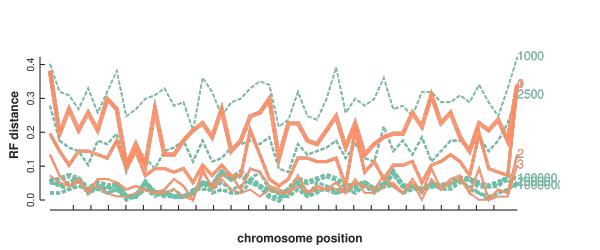

In [366]:
canvas, axes = plot_gene_tree_RFs(slider_50_2.results);
toyplot.svg.render(canvas, "../manuscript/figures/Fig-3-pre-50-2.svg")
canvas

In [381]:
slider_50_2.results[slider_50_2.results.window == 3].RF.mean()

0.03216494845360825

In [386]:
slider_50_2.results[slider_50_2.results.window == 10000].RF.mean()

0.03402061855670103

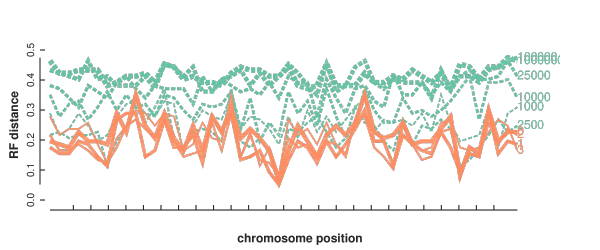

In [389]:
canvas, axes = plot_gene_tree_RFs(slider_50_02.results);
toyplot.svg.render(canvas, "../manuscript/figures/Fig-3-pre-50-02.svg")
canvas

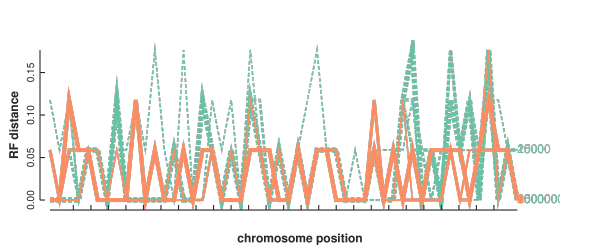

In [417]:
canvas, axes = plot_gene_tree_RFs(slider_10_2.results);
#toyplot.svg.render(canvas, "../manuscript/figures/Fig-3-pre-50-02.svg")
canvas

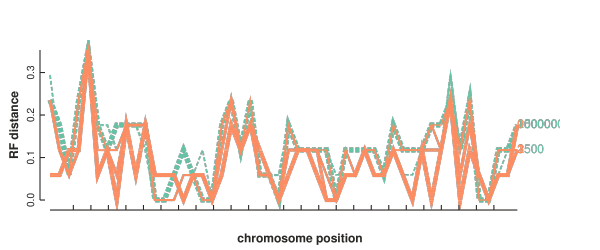

In [404]:
canvas, axes = plot_gene_tree_RFs(slider_10_1_10.results);
#toyplot.svg.render(canvas, "../manuscript/figures/Fig-3-pre-50-02.svg")
canvas

### Plot Weight Distributions

In [418]:
mods = [
    #slider_10_02, slider_10_1, slider_10_2, 
    #slider_10_1_10, 
    slider_50_02, slider_50_2,
]

for mod in mods:
    simod = copy.deepcopy(mod)

    wsizes = simod.results.window.unique()
    for wz in wsizes:
        print(wz, simod.results[simod.results.window == wz].RF.mean())

    res = get_exponential_weight_window(simod.model.seqs[0], 500000, simod.decay_rate*10, 10000)
    start, end, seq, wgts = res
    print(seq.shape[1])
    res = get_exponential_weight_window(simod.model.seqs[0], 500000, simod.decay_rate*5, 10000)
    start, end, seq, wgts = res
    print(seq.shape[1])
    res = get_exponential_weight_window(simod.model.seqs[0], 500000, simod.decay_rate*2, 10000)
    start, end, seq, wgts = res
    print(seq.shape[1])
    res = get_exponential_weight_window(simod.model.seqs[0], 500000, simod.decay_rate, 10000)
    start, end, seq, wgts = res
    print(seq.shape[1])     
        
    print("")

1000000 0.41608247422680406
1000 0.263298969072165
2500 0.22288659793814433
10000 0.31030927835051547
25000 0.37278350515463915
100000 0.40845360824742266
0 0.2169072164948453
1 0.1832989690721649
2 0.18618556701030925
3 0.21711340206185561
4887
9773
24433
48867

1000000 0.04474226804123711
1000 0.30061855670103094
2500 0.15649484536082472
10000 0.03402061855670103
25000 0.027628865979381446
100000 0.041030927835051544
0 0.21175257731958763
1 0.11216494845360822
2 0.04927835051546391
3 0.03216494845360825
61175
122351
305877
611755

